In [51]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [52]:
DATASET_PATH = "D:/new project taarlab/Dataset/"
blender_path = os.path.join(DATASET_PATH, "Blender/")
light_switch = os.path.join(DATASET_PATH, "Light_Switch/")
toaster = os.path.join(DATASET_PATH, "Toaster/")
water = os.path.join(DATASET_PATH, "Water/")

In [53]:
AUDIO_CLASSES = ["Blender", "Light_Switch", "Toaster", "Water"]

In [54]:
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
def load_and_preprocess_audio(dataset_path, classes, sr=22050, n_mels=128, max_frames=216):
    X, y = [], []
    for idx, label in enumerate(classes):
        class_path = os.path.join(dataset_path, label)
        for file_name in os.listdir(class_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_path, file_name)
                audio, _ = librosa.load(file_path, sr=sr)
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                if mel_spec_db.shape[1] > max_frames:  
                    mel_spec_db = mel_spec_db[:, :max_frames]
                else:  
                    pad_width = max_frames - mel_spec_db.shape[1]
                    mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')

                X.append(mel_spec_db)
                y.append(idx)
    X = np.array(X)
    y = np.array(y)
    return X, y



X, y = load_and_preprocess_audio(DATASET_PATH, AUDIO_CLASSES)

y = to_categorical(y, num_classes=len(AUDIO_CLASSES))


X = X / np.max(X)
X = np.expand_dims(X, axis=-1)

print(f"size X: {X.shape}")
print(f"size y: {y.shape}")

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"size X_train: {X_train.shape}")
print(f"size X_test: {X_test.shape}")


print(f"size Y_train: {y_train.shape}")
print(f"size Y_test: {y_test.shape}")


input_shape = X_train[0].shape
print(input_shape)
input_layer = Input(shape=input_shape)


conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)


flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dense1 = Dropout(0.3)(dense1)
output_layer = Dense(len(AUDIO_CLASSES), activation='softmax')(dense1)

from sklearn.utils.class_weight import compute_class_weight

model = Model(inputs=input_layer, outputs=output_layer)

# class_weights = compute_class_weight("balanced", classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
# class_weights_dict = {i: class_weights[i] for i in range(len(AUDIO_CLASSES))}

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


layers = [conv1, pool1, conv2, pool2, conv3, pool3]
feature_extractor = Model(inputs = model.input, outputs = layers)

sample_features = feature_extractor.predict(np.expand_dims(X_test[0], axis=0))

for idx, feature_map in enumerate(sample_features):
    print(f"Layer {idx+1} output shape: {feature_map.shape}")


size X: (136, 128, 216, 1)
size y: (136, 4)
size X_train: (108, 128, 216, 1)
size X_test: (28, 128, 216, 1)
size Y_train: (108, 4)
size Y_test: (28, 4)
(128, 216, 1)
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4515 - loss: 16.0026 - val_accuracy: 0.4286 - val_loss: 133.2721
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.8162 - loss: 2.3965 - val_accuracy: 0.4286 - val_loss: 147.8466
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.9334 - loss: 0.6138 - val_accuracy: 0.4286 - val_loss: 154.7101
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9575 - loss: 0.4750 - val_accuracy: 0.4286 - val_loss: 161.4727
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.9058 - loss: 0.4150 - val_accuracy: 0.3929 - val_loss: 175.6010
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.9461 - loss: 0.8864 - val_accuracy: 0.4286 - val_loss: 156.7172
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.9

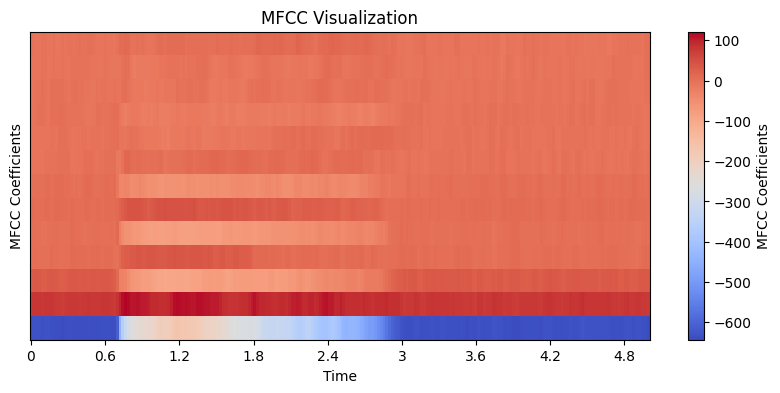

In [55]:
def plot_mfcc(file_path, sr=22050, n_mfcc=13):
    audio, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar(label='MFCC Coefficients')
    plt.title('MFCC Visualization')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.show()
    
plot_mfcc("D:/new project taarlab/Dataset/Blender/16.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


<Figure size 800x600 with 0 Axes>

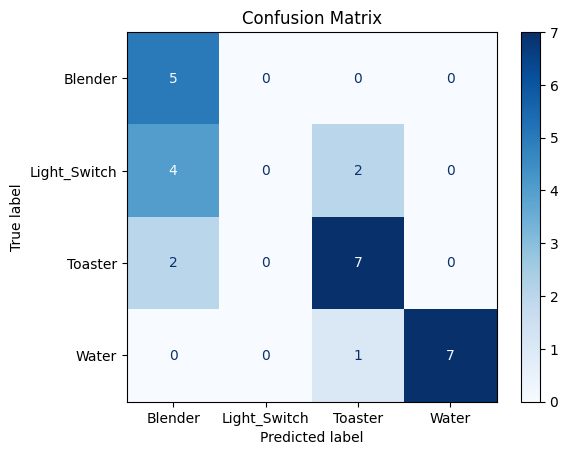

In [56]:
y_pred_probs = model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.argmax(y_test, axis=1)  


cm = metrics.confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(cm, AUDIO_CLASSES)

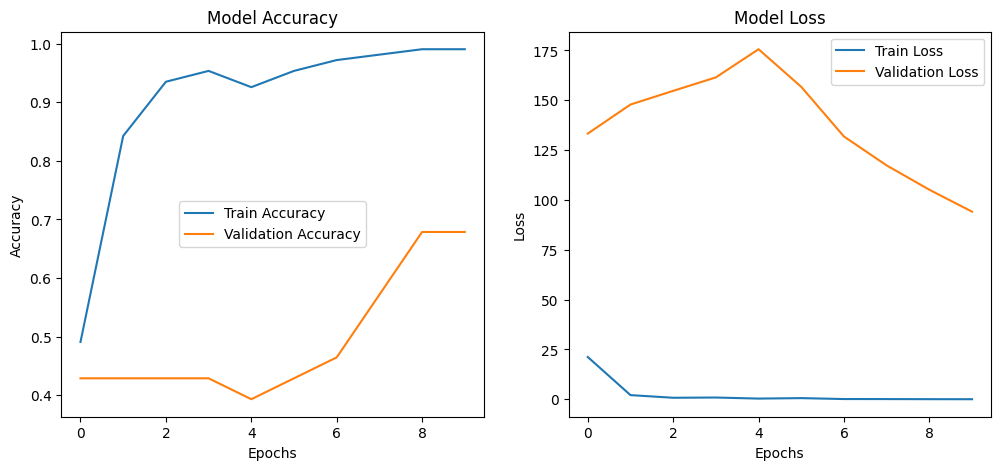

In [57]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [58]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 216, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,515,406 (82.07 MB)

 Trainable params: 7,171,652 (27.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 14,343,306 (54.72 MB)

In [59]:
from scipy.ndimage import zoom

def resize_feature_map(feature, target_shape):
    """Resize feature map to match the target shape."""
    zoom_factors = [target / source for target, source in zip(target_shape, feature.shape)]
    return zoom(feature, zoom_factors, order=1)  # Linear interpolation


In [60]:
def extract_features(model, X, layers):
    feature_extractor = Model(inputs=model.input, outputs=layers)
    return feature_extractor.predict(X)

In [61]:
def check_similarity(features1, features2, similarity_method):
    if features1.shape != features2.shape:
        features2 = resize_feature_map(features2, features1.shape)  # Resize to match
    if similarity_method == "cosine":
        return 1 - cosine(features1.flatten(), features2.flatten())
    elif similarity_method == "euclidean":
        return -np.linalg.norm(features1 - features2)

In [62]:
def find_most_similar(features, idx, feature_idx, metric="cosine"):
    print("idx: ", idx)
    print("feature_idx: ", feature_idx)
    reference_feature = features[idx][feature_idx] #find the exact feature that we are working with right now
    similarities = []
    for j in range(len(features[idx])):
        if j != feature_idx:
            candidate_feature = features[idx][j]
            similarity = check_similarity(reference_feature, candidate_feature, metric)
            similarities.append(similarity)
    most_similar_idx = np.argmax(similarities)
    return most_similar_idx, similarities[most_similar_idx]

In [63]:
def compare_outputs(model, X, idx, most_similar_idx):
    original_output = model.predict(np.expand_dims(X[idx], axis=0))
    similar_output = model.predict(np.expand_dims(X[most_similar_idx], axis=0))
    return np.allclose(original_output, similar_output), original_output, similar_output

In [64]:
def calculate_seperation_index(seperation_idx, output):
    return (seperation_idx[output] + 1)

In [65]:
feature_layers = [conv1, pool1, conv2, pool2, conv3, pool3]


In [66]:
seperation_idx = [[0 for _ in range(6)] for _ in range(len(AUDIO_CLASSES))]

def analyze_features_and_outputs(model, X, feature_layers):
    
    features = extract_features(model, X, feature_layers)
    print(f"Extracted {len(features)} feature sets")
    results = []
    print(f"Number of feature sets extracted: {len(features)}") 
    for i, feature_set in enumerate(features):
        print(f"Feature set {i} has {len(feature_set)} layers")


    # seperation_idx = [output for i,output in enumerate(AUDIO_CLASSES)]

    for layer_idx, feature_set in enumerate(features):
        print(f"Layer {layer_idx} has {len(feature_set)} features")
        for feature_idx in range(len(feature_set)):
            
            most_similar_idx, similarity = find_most_similar(features, idx, feature_idx)
    
            
            same_output, original_output, similar_output = compare_outputs(
                model, X, idx, most_similar_idx
            )
            
            print("this is original output:", original_output)
            class_idx = np.argmax(original_output) #this is always returning 1
            
            if(same_output):
                print("yes, same output")
                seperation_idx[class_idx][layer_idx] += 1 #
            
            results.append({
                "layer_idx": layer_idx,
                "feature_idx": feature_idx,
                "most_similar_idx": most_similar_idx,
                "similarity": similarity,
                "same_output": same_output,
                "original_output": original_output,
                "similar_output": similar_output
            })
    
    return results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Extracted 6 feature sets
Number of feature sets extracted: 6
Feature set 0 has 28 layers
Feature set 1 has 28 layers
Feature set 2 has 28 layers
Feature set 3 has 28 layers
Feature set 4 has 28 layers
Feature set 5 has 28 layers
Layer 0 has 28 features
idx:  5
feature_idx:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
this is original output: [[1. 0. 0. 0.]]
yes, same output
idx:  5
feature_idx:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
this is original output: [[1. 0. 0. 0.]]
idx:  5
feature_idx:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
this is original output: [[1. 0. 0. 0.]]
yes, same output
idx:  5
feature_idx:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
this is original output: [[1. 0. 0. 0.]]
yes, same output
idx:  5
feature_idx:  4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

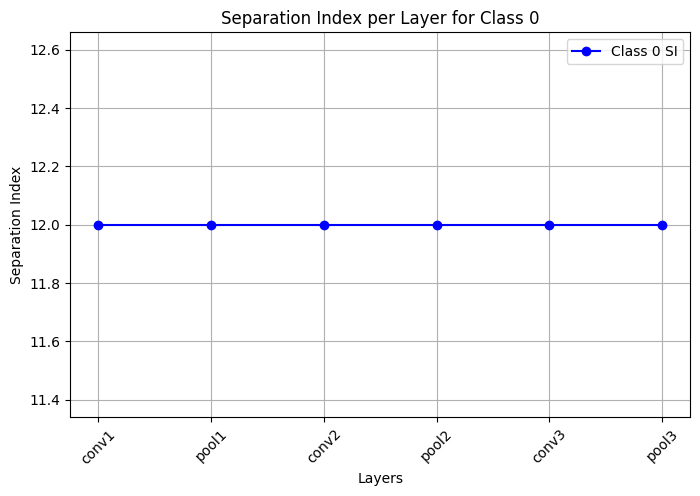

In [67]:
import matplotlib.pyplot as plt

def plot_SI_per_layer(seperation_idx, class_idx, layer_names):
    num_layers = len(layer_names)

    # Extract SI values for the selected class
    si_values = [seperation_idx[class_idx][layer] for layer in range(num_layers)]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(layer_names, si_values, marker='o', linestyle='-', color='b', label=f'Class {class_idx} SI')
    plt.xlabel("Layers")
    plt.ylabel("Separation Index")
    plt.title(f"Separation Index per Layer for Class {class_idx}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    
feature_layers = [conv1, pool1, conv2, pool2, conv3, pool3]
results = analyze_features_and_outputs(model, X_test, feature_layers)


for res in results:
    print(f"Layer {res['layer_idx']} - Feature {res['feature_idx']} - Similarity: {res['similarity']:.4f} - Same Output: {res['same_output']}")
   
print("\nSeparation Index Matrix:")
for row in seperation_idx:
    print(row)
 
class_idx = 0
layer_names = ["conv1", "pool1", "conv2", "pool2", "conv3", "pool3"]
plot_SI_per_layer(seperation_idx, class_idx, layer_names)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (4, 6).

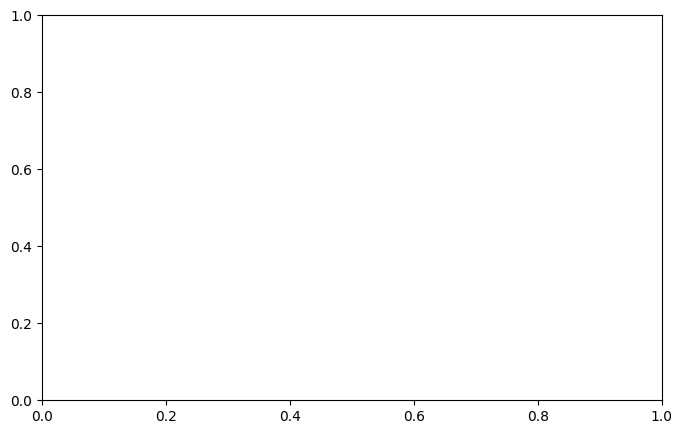

In [68]:
import matplotlib.pyplot as plt

def plot_separation_index(separation_idx, class_names, class_idx):

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(separation_idx)), separation_idx, color='blue', alpha=0.7)
    plt.xlabel("Layers")
    plt.ylabel("Separation Index")
    plt.title(f"Separation Index for {class_names[class_idx]}")
    plt.xticks(range(len(separation_idx)), labels=[f"Layer {i+1}" for i in range(len(separation_idx))], rotation=45)
    plt.show()

# feature_layers = [conv1, pool1, conv2, pool2, conv3, pool3]
# results = analyze_features_and_outputs(model, X_test, feature_layers)


# for res in results:
#     print(f"Layer {res['layer_idx']} - Feature {res['feature_idx']} - Similarity: {res['similarity']:.4f} - Same Output: {res['same_output']}")

class_idx = 0  
plot_separation_index(seperation_idx, AUDIO_CLASSES, class_idx)
